# **1. competition 살펴보기**
<hr>

## *Overview*

* 목적: 택시로 이동(trip)하는 시간 예측하기 in New York
* 평가 방법: Root Mean Squared Logarithmic Error(RMSLE)를 이용하여 성능을 evaluation한다.
$$ \epsilon = \sqrt{\frac{1}{n}\sum_{i=1}^{n}(log(p_{i}+1)-log(a_{i}+1))^2} $$
* $ \epsilon $: RMSLE value (score)
* n: data set에서의 총 관찰 대상 수
* $ p_{i} $: 예측한 i의 이동 시간
* $ a_{i} $: 실제 i의 이동시간
* log는 자연 로그

# **2. Data 살펴보기**
<hr>

# *File Description*
* train.csv: 1,458,644 samples - 약 146만 개의 샘플
* test.csv: 625,134 samples - 약 62만 개의 샘플
* sample_submission.csv

## *Data fields* 
* id: 각 운행 별 인덱스(식별자)
* vendor_id: 운행 기록 제공 회사를 나타내는 코드
* pickup_datetime: 승객이 탑승한 날짜와 시간
* dropoff_datetime: 승객이 하차한 날짜와 시간
* passenger_count: 차량 내 승객 수(운전자 포함)
* pickup_longitude: 승객이 탑승한 경도
* pickup_latitude: 승객이 탑승한 위도
* dropoff_longitude: 승객이 하차한 경도
* dropoff_latitude: 승객이 하차한 위도
* store_and_fwd_flag: 차량이 서버에 연결되지 않았기 때문에 회사에 전송하기 전에 차량 메모리에 주행기록을 저장했는지 여부 표시
 * Y: store and forward
 * N: not a store and forward trip
* trip_duration: 이동 기간(초 단위)

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

os.getcwd()

In [ ]:
!unzip '../input/nyc-taxi-trip-duration/train.zip'
!unzip '../input/nyc-taxi-trip-duration/test.zip'
!unzip '../input/nyc-taxi-trip-duration/sample_submission.zip'

In [ ]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')
submission = pd.read_csv('./sample_submission.csv')


## *train set 살펴보기*
head(), info(), describe() 를 사용해서 train 데이터셋을 살펴봅시다.

In [ ]:
train.head() # 상위 5개 samples

In [ ]:
train.info() # 데이터셋 크기, 결측치, 데이터 타입 체크

# (145만 x 11) -> samples: 145만 개, fields: 11개

print(train.shape[0])
print(train.shape[1])

train.isnull().sum()

* 결측치 없다.
* object 타입인 데이터가 4개 존재: id, datetime, store_and_fwd_flag -> 훈련에 사용할 시 encode 필요하다.

In [ ]:
train.describe()

## *test set 살펴보기*

In [ ]:
test.head()

In [ ]:
test.info()

train set이랑 비교해서 컬럼이 2개 부족함 <br>
dropoff_datetime을 예측해서 trip_duration을 맞춰야하기 때문 <br>
<br>
아래의 feature들을 이용해서 trip_duration을 예측해보면 된다!
* pickup_datetime & dropoff_datetime
* pickup_longtitude, pickup_latitude & dropoff_longtitude, dropoff_latitude
* store_and_fwd_flag

# **3. Data 시각화**

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

가장 중요한 trip duration 데이터가 어떻게 분포하고 있는지 살펴보자! <br>
우선 데이터의 min, max 값을 보자.



In [ ]:
print(f"min_value is '{min(train['trip_duration'])}' and max_value is '{max(train['trip_duration'])}'")

최소 값과 최대 값의 차이가 100만이 넘는다. <br>
이렇게 데이터 간의 편차가 큰 경우에 log-scale로 데이터를 살펴보면 좋다. <br>

## *- 로그 스케일*

데이터 간의 편차가 클 때 plot을 하면 크기가 큰 값에 의해 작은 값이 보이지 않게 된다.  <br>
이럴 때 데이터에 로그를 취하면, 상대적으로 크기가 작은 데이터 간의 차이도 잘 볼 수 있다. <br>
즉, 크기의 차이를 상대적으로 볼 수 있다.

In [ ]:
plt.scatter([1,2],[1,10])

In [ ]:
plt.scatter([1,2,3],[1,10,1000])

In [ ]:
y=[1,10,1000]
y = np.array(y)


plt.scatter([1,2,3],np.log(y),color='r') # 자연로그(밑: e)
plt.scatter([1,2,3],np.log10(y),color='b') # 상용로그(밑: 10)

In [ ]:
train['trip_duration'] = np.log(train['trip_duration'].values)

In [ ]:
sns.histplot(train['trip_duration'].values)

In [ ]:
plt.hist(train['trip_duration'].values, bins=100)
plt.xlabel('log(trip_duration)')
plt.ylabel('number of records')
plt.show()

In [ ]:
plt.scatter(range(train.shape[0]),train['trip_duration'])

In [ ]:
train = train[train.trip_duration<train.trip_duration.quantile(0.98)]
train = train[train.trip_duration>train.trip_duration.quantile(0.01)]

In [ ]:
plt.scatter(range(train.shape[0]),train['trip_duration'])

# *- heatmap으로 데이터 간 관계 살펴보기*

In [ ]:
cor_matrix = train.corr().round(2)

fig = plt.figure(figsize = (15,10))
sns.heatmap(cor_matrix, annot = True, center = 0,
           cmap = sns.diverging_palette(250, 10, as_cmap = True),
           ax = plt.subplot(111))

plt.show()

승하차 위도, 경도를 제외하고는 상관도가 큰 feature가 없다. <br>
왜냐하면 아직 날짜를 년/월/일/시로 나누지 않았고 위도, 경도를 거리로 환산하지 않았기 때문이다. <br>

# *- Date 정보 시각화*

In [ ]:
train['pickup_datetime'] = pd.to_datetime(train['pickup_datetime'])


train['month'] = train['pickup_datetime'].dt.month
train['day'] = train['pickup_datetime'].dt.day
train['dayofweek'] = train['pickup_datetime'].dt.dayofweek
train['hour'] = train['pickup_datetime'].dt.hour

In [ ]:
sns.countplot(train['month'])

In [ ]:
sns.countplot(train['day'])

In [ ]:
sns.countplot(train['dayofweek'])

In [ ]:
sns.countplot(train['hour'])

In [ ]:
cor_matrix = train.corr().round(2)

fig = plt.figure(figsize = (15,10))
sns.heatmap(cor_matrix, annot = True, center = 0,
           cmap = sns.diverging_palette(250, 10, as_cmap = True),
           ax = plt.subplot(111))

plt.show()

# **- pickup & dropoff 위치 이상치 확인**

In [ ]:
pickup_lng = list(train.pickup_longitude)
pickup_lat = list(train.pickup_latitude)
plt.subplots(figsize=(15,10))
plt.plot(pickup_lng, pickup_lat,'.', alpha=1, markersize=10)
plt.xlabel('pickup_longitude')
plt.ylabel('pickup_latitude')
plt.show()

In [ ]:
train = train[(train.pickup_longitude > -100.0 )]
train = train[(train.pickup_latitude <50.0 )]

In [ ]:
drop_lng = list(train.dropoff_longitude)
drop_lat = list(train.dropoff_latitude)
plt.subplots(figsize=(15,10))
plt.plot(drop_lng,drop_lat,'.', alpha=1, markersize=10)
plt.xlabel('dropoff_longitude')
plt.ylabel('dropoff_latitude')
plt.show()

In [ ]:
train = train[(train.dropoff_longitude < -65.0 )]
train = train[(train.dropoff_latitude > 36.0 )]

# *- 다양한 거리 계산 방법*

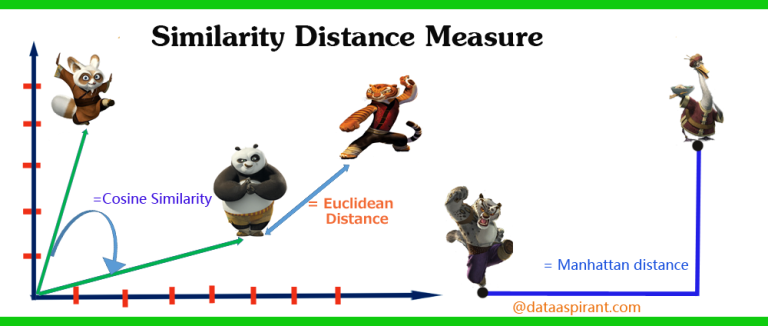   
(ref.: https://dataaspirant.com/five-most-popular-similarity-measures-implementation-in-python/)


* Euclidean distance
* Manhattan distance
* Haversine

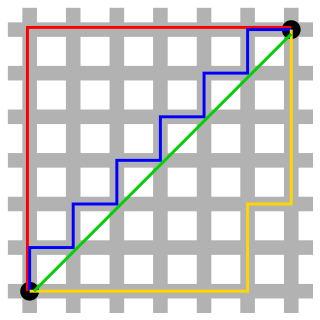
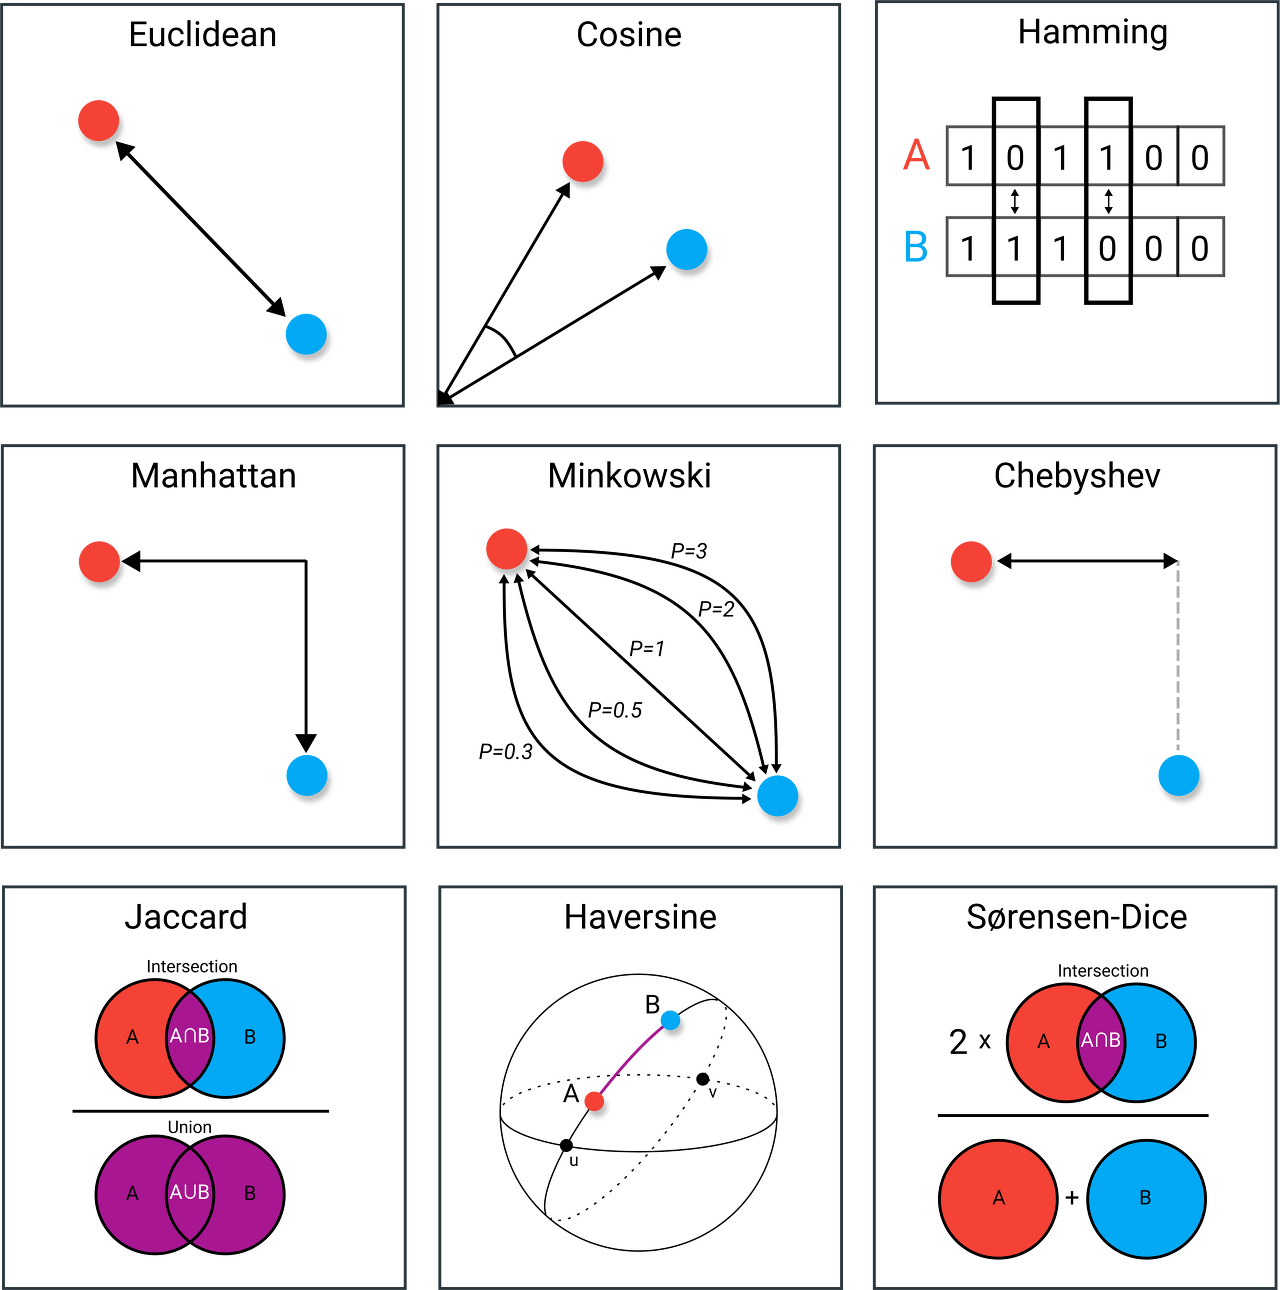


# **-- 1. Euclide distance**
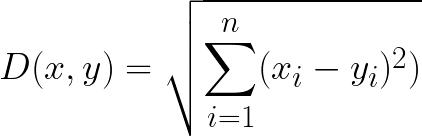

In [ ]:
train['Euclide_D']=np.sqrt((train['pickup_longitude']-train['dropoff_longitude'])**2+(train['pickup_latitude']-train['dropoff_latitude'])**2)
train['Euclide_D']

cor_matrix = train.corr().round(2)

fields = ['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude']

cor_matrix.drop(fields,inplace=True)
cor_matrix.drop(fields,axis=1, inplace=True)

fig = plt.figure(figsize = (15,10))
sns.heatmap(cor_matrix, annot = True, center = 0,
           cmap = sns.diverging_palette(250, 10, as_cmap = True),
           ax = plt.subplot(111))

plt.show()


# **-- 2. Manhattan distance**
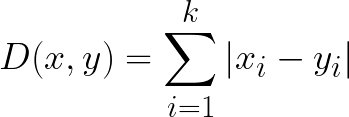

In [ ]:
train['Manhattan_D']=np.abs(train['pickup_latitude']-train['dropoff_latitude']) + np.abs(train['pickup_longitude']-train['dropoff_longitude'])

cor_matrix = train.corr().round(3)

fields = ['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude']

cor_matrix.drop(fields,inplace=True)
cor_matrix.drop(fields,axis=1, inplace=True)

fig = plt.figure(figsize = (15,10))
sns.heatmap(cor_matrix, annot = True, center = 0,
           cmap = sns.diverging_palette(250, 10, as_cmap = True),
           ax = plt.subplot(111))

plt.show()

# **-- 3. 하버사인**
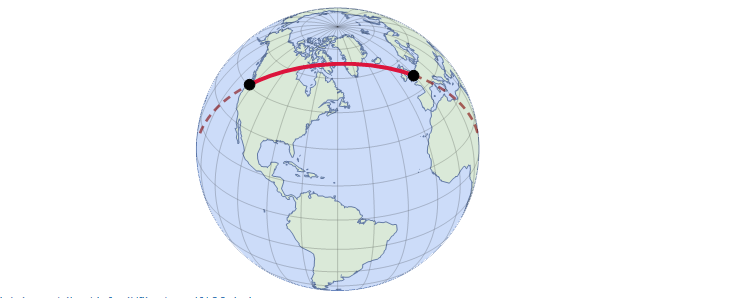
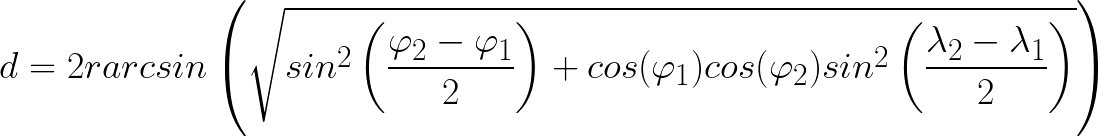

In [ ]:
def haversine_(pick_lat, pick_lng, drop_lat, drop_lng):
    pick_lat, pick_lng, drop_lat, drop_lng = map(np.radians, (pick_lat, pick_lng, drop_lat, drop_lng))
    AVG_EARTH_RADIUS = 6371 #km
    lat = pick_lat - drop_lat
    lng = pick_lng - drop_lng
    distance = np.sin(lat/2)**2 + np.cos(pick_lat)*np.cos(drop_lat)*np.sin(lng/2)**2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(distance))
    return h

train['Haversine_D'] = haversine_(train['pickup_latitude'].values,
                                              train['pickup_longitude'].values,
                                              train['dropoff_latitude'].values,
                                              train['dropoff_longitude'].values)

In [ ]:
cor_matrix = train.corr().round(3)

fields = ['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude']

cor_matrix.drop(fields,inplace=True)
cor_matrix.drop(fields,axis=1, inplace=True)

fig = plt.figure(figsize = (15,10))
sns.heatmap(cor_matrix, annot = True, center = 0,
           cmap = sns.diverging_palette(250, 10, as_cmap = True),
           ax = plt.subplot(111))

plt.show()

# **-- 4. 하버사인 + 맨허튼**

In [ ]:
def manhattan_distance_pd(pick_lat, pick_lng, drop_lat, drop_lng):
    a = haversine_(pick_lat, pick_lng, pick_lat, drop_lng)
    b = haversine_(pick_lat, pick_lng, drop_lat, pick_lng)
    return a+b

train['Hav+Man_D'] = manhattan_distance_pd(train['pickup_latitude'].values,
                                              train['pickup_longitude'].values,
                                              train['dropoff_latitude'].values,
                                              train['dropoff_longitude'].values)

In [ ]:
cor_matrix = train.corr().round(5)

fields = ['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude']

cor_matrix.drop(fields,inplace=True)
cor_matrix.drop(fields,axis=1, inplace=True)

fig = plt.figure(figsize = (15,10))
sns.heatmap(cor_matrix, annot = True, center = 0,
           cmap = sns.diverging_palette(250, 10, as_cmap = True),
           ax = plt.subplot(111))

plt.show()